In [1]:
import overpy
import geopandas as gpd
import os
from shapely.geometry import Polygon, MultiPolygon, shape
import json
import glob
from shapely.ops import split
from shapely.geometry import LineString, GeometryCollection
import matplotlib.pyplot as plt


os.chdir('D:')
print(os.getcwd())

d:\Documents\EPFL\PdM\roads_master


In [100]:
output_dir = "./roads"
os.makedirs(output_dir, exist_ok=True)

api = overpy.Overpass(
    
)

In [2]:
gdf_urban_centres = gpd.read_file('./urban_centres/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
#gdf_pekin = gpd.read_file('beijing.geojson')



AttributeError: module 'fiona' has no attribute 'path'

In [102]:
gdf_urban_centres.head()

,ID_HDC_G0,QA2_1V,AREA,BBX_LATMN,BBX_LONMN,BBX_LATMX,BBX_LONMX,GCPNT_LAT,GCPNT_LON,CTR_MN_NM,...,EX_SS_P00,EX_SS_P15,EX_EQ19PGA,EX_EQ19MMI,EX_EQ19_Q,EX_HW_IDX,SDG_LUE9015,SDG_A2G14,SDG_OS15MX,geometry
0,1.0,1.0,185.0,21.247683,-158.043016,21.422193,-157.730529,21.340678,-157.893497,United States,...,397443.031445,444041.529529,NaN,NaN,missing,NaN,0.074385,0.226415,56.41,"MULTIPOLYGON (((-158.01244 21.42219, -157.9915..."
1,2.0,2.0,42.0,-17.641184,-149.628088,-17.517631,-149.508018,-17.534103,-149.568053,French Polynesia,...,0.000000,0.000000,NaN,NaN,missing,NaN,0.128,0.284119,NaN,"MULTIPOLYGON (((-149.56967 -17.51763, -149.508..."
2,3.0,1.0,55.0,34.858517,-120.475511,34.989334,-120.389183,34.923123,-120.434372,United States,...,0.000000,0.000000,0.0,0.0,available,2.79174,0.48114,0.040129,23.64,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411..."
3,4.0,1.0,48.0,36.582997,-121.952215,36.635743,-121.811816,36.607720,-121.882378,United States,...,0.000000,0.000000,0.0,0.0,available,NaN,0.44484,0.138683,42.17,"MULTIPOLYGON (((-121.95221 36.63574, -121.9179..."
4,5.0,1.0,60.0,34.388220,-119.853855,34.457831,-119.658413,34.427664,-119.743693,United States,...,0.000000,0.000000,0.0,0.0,available,4.25502,0.55676,0.061348,36.50,"MULTIPOLYGON (((-119.82444 34.45783, -119.8131..."


In [ ]:

# def query_highways(polygon):
#     """
#     Query highways (excluding footway, pedestrian, path) within a given polygon.

#     :param polygon: List of (lat, lon) tuples defining the polygon
#     :return: Overpass API query result
#     """
#     # Convert polygon coordinates to Overpass format
#     polygon_str = " ".join(f"{lat} {lon}" for lat, lon in polygon)
    
#     # Overpass API query
#     query = f"""
#     [out:json][timeout:25];
#     (
#       way["highway"]["highway"!="footway"]["highway"!="pedestrian"]["-highway"!="path"]
#       (poly:"{polygon_str}");
#     );
#     (._;>;);
#     out body;
#     """
    
#     # Execute the query
#     return api.query(query)


#for idx, poly in enumerate(polygons):
#    print(f"Querying polygon {idx + 1}")
#    result = query_highways(poly)
    


# Overpass API query template
query_template = """
[out:json][timeout:1000];
(
  way["highway"]
  ["highway"!~"footway|pedestrian|path"]
  (poly:"{poly_coords}");
);
out body;
>;
out skel qt;
"""


def polygon_to_overpass_coords(geometry):
    """
    Converts a Shapely geometry (Polygon or MultiPolygon) to Overpass-compatible coordinates.
    """
    if geometry.is_valid:
        if geometry.geom_type == "Polygon":
            exterior = geometry.exterior.coords
            return " ".join(f"{lat} {lon}" for lon, lat in exterior)
        elif geometry.geom_type == "MultiPolygon":
            #largest polygon by area
            largest_poly = max(geometry.geoms, key=lambda g: g.area)
            exterior = largest_poly.exterior.coords
            return " ".join(f"{lat} {lon}" for lon, lat in exterior)
    else:
        raise ValueError("Invalid geometry")



def generate_filename(row):
    """
    Generates a filename for the output GeoJSON file based on the urban center's ID, country, and city name.
    Ensures that the filename is valid across operating systems.
    Converts ID to an integer to avoid floating-point representation in filenames.
    """
    urban_id = int(row['ID_HDC_G0'])  # Convert to integer to remove the decimal
    country = row['XC_NM_LST'].replace(" ", "_").replace("|", "_")
    city = row['UC_NM_MN'].replace(" ", "_").replace("|", "_")
    return f"./roads/{urban_id}_{country}_{city}.geojson"







In [ ]:
def process_urban_center(row,empty):
    id_hdc = int(row['ID_HDC_G0'])  # Convert to integer to remove the decimal
    country = row['XC_NM_LST'].replace(" ", "_").replace("|", "_")
    city = row['UC_NM_MN'].replace(" ", "_").replace("|", "_")
    geometry = row["geometry"]
    filename = generate_filename(row)
    fallback_filename = f"./roads/{id_hdc}.geojson"
    empty_filename = f"./roads/{id_hdc}_empty.geojson"

    if os.path.exists(filename):
        print(f"File {filename} already exists. Skipping query.")
        return
    if os.path.exists(fallback_filename):
        print(f"File {fallback_filename} already exists. Skipping query.")
        return
    if os.path.exists(empty_filename):
        print(f"File {empty_filename} already exists. Skipping query.")
        return

    try:
        #convert geometry to Overpass polygon format
        poly_coords = polygon_to_overpass_coords(geometry)

        # format query with polygon coordinates
        query = query_template.format(poly_coords=poly_coords)

        # Fetch using Overpass API
        result = api.query(query)

        #extract highways as geometries
        highways = []
        for way in result.ways:
            points = [(float(node.lon), float(node.lat)) for node in way.nodes]
            if len(points) > 2:  # Ensure it's a valid geometry
                highways.append({
                    "type": "Feature",
                    "properties": {"id": way.id, "tags": way.tags},
                    "geometry": {
                        "type": "LineString",
                        "coordinates": points,
                    },
                })

        # save to GeoJSON
        if highways:
            geojson_data = {
                "type": "FeatureCollection",
                "features": highways
            }
            try:
                # Attempt to save the file with the full filename
                with open(filename, "w") as f:
                    json.dump(geojson_data, f, indent=2)
                print(f"Saved: {filename}")
            except Exception as save_error:
                # If saving fails, attempt to save with just the ID
                try:
                    with open(fallback_filename, "w") as f:
                        json.dump(geojson_data, f, indent=2)
                    print(f"Failed to save as {filename}. Saved as {fallback_filename} instead.")
                except Exception as fallback_error:
                    print(f"Critical error: Failed to save as {filename} and {fallback_filename}.")
                    print(f"Original save error: {save_error}")
                    print(f"Fallback save error: {fallback_error}")
        elif(empty):
            # Create an empty file with "_empty" in its name
            try:
                empty_geojson_data = {
                    "type": "FeatureCollection",
                    "features": []
                }
                with open(empty_filename, "w") as f:
                    json.dump(empty_geojson_data, f, indent=2)
                print(f"No highways found for {city}, {country} (ID: {id_hdc}). Saved empty file: {empty_filename}")
            except Exception as empty_error:
                print(f"Error saving empty file for {city}, {country} (ID: {id_hdc}): {empty_error}")

    except Exception as e:
        print(f"Error processing {city}, {country} (ID: {id_hdc}): {e}")


In [108]:
empty = True
for _, row in gdf_urban_centres.iterrows():
    process_urban_center(row,empty)

print("Processing complete!")

File ./roads/1_United_States_Honolulu.geojson already exists. Skipping query.
File ./roads/2_French_Polynesia_Papeete.geojson already exists. Skipping query.
File ./roads/3_United_States_Santa_Maria.geojson already exists. Skipping query.
File ./roads/4_United_States_Monterey.geojson already exists. Skipping query.
File ./roads/5_United_States_Santa_Barbara.geojson already exists. Skipping query.
File ./roads/6_United_States_Santa_Cruz.geojson already exists. Skipping query.
File ./roads/7_United_States_Salinas.geojson already exists. Skipping query.
File ./roads/8_United_States_Oxnard.geojson already exists. Skipping query.
File ./roads/9_United_States_Watsonville.geojson already exists. Skipping query.
File ./roads/10_United_States_San_Jose.geojson already exists. Skipping query.
File ./roads/11_United_States_Camarillo.geojson already exists. Skipping query.
File ./roads/12_United_States_Thousand_Oaks.geojson already exists. Skipping query.
File ./roads/13_United_States_San_Rafael.ge

In [ ]:

def find_missing_files_with_id(gdf, folder_path):
    """
    Checks if all urban centers in the GeoDataFrame have a corresponding file
    in the folder. Matches files based on the exact ID at the start of the filename.

    :param gdf: GeoDataFrame with urban center information.
    :param folder_path: Path to the folder containing the files.
    :return: List of dictionaries with information on missing files.
    """
    missing_files = []

    for _, row in gdf.iterrows():
        urban_id = int(row['ID_HDC_G0'])  # convert to integer to match file naming
        # look for files starting with the ID
        file_pattern = os.path.join(folder_path, f"{urban_id}*.geojson")
        matching_files = glob.glob(file_pattern)

        #ensure the match is exact (ID followed by .geojson or _)
        exact_match = any(
            os.path.basename(f) == f"{urban_id}.geojson" or os.path.basename(f).startswith(f"{urban_id}_")
            for f in matching_files
        )

        if not exact_match:
            # No matching file found
            missing_files.append({
                "ID": urban_id,
                "Country": row['XC_NM_LST'],
                "City": row['UC_NM_MN'],
                "Reason": "File not found"
            })

    return missing_files

folder_path = "./roads"
missing_cities = find_missing_files_with_id(gdf_urban_centres, folder_path)

#list of missing cities
if missing_cities:
    print("The following cities are missing:")
    for city in missing_cities:
        print(f"ID: {city['ID']}, Country: {city['Country']}, City: {city['City']}, Reason: {city['Reason']}")
else:
    print("All urban centers have valid files.")


All urban centers have valid files.


In [122]:
missing_cities

[]

In [ ]:
'''

def divide_polygon(polygon):
    """
    Divides a polygon into four smaller polygons by splitting it along its centroid's axes.
    
    :param polygon: A Shapely Polygon geometry.
    :return: A list of divided polygons.
    """
    if polygon.is_empty or not polygon.is_valid:
        return []

    # Get the bounds and centroid of the polygon
    bounds = polygon.bounds  # (minx, miny, maxx, maxy)
    centroid = polygon.centroid  # (x, y)

    # Create vertical and horizontal split lines
    vertical_line = LineString([(centroid.x, bounds[1]), (centroid.x, bounds[3])])
    horizontal_line = LineString([(bounds[0], centroid.y), (bounds[2], centroid.y)])

    # Split the polygon into two parts vertically and then horizontally
    divided = split(polygon, vertical_line)
    divided = [part for geom in divided for part in split(geom, horizontal_line)]

    return [part for part in divided if part.is_valid and not part.is_empty]

'''
    


def divide_polygon(polygon):
    """
    Divides a polygon into four smaller polygons by splitting it along its centroid's axes.
    
    :param polygon: A Shapely Polygon geometry.
    :return: A list of divided polygons.
    """
    if polygon.is_empty or not polygon.is_valid:
        return []

    #get the bounds and centroid of the polygon
    bounds = polygon.bounds  # (minx, miny, maxx, maxy)
    centroid = polygon.centroid  # (x, y)

    #create vertical and horizontal split lines
    vertical_line = LineString([(centroid.x, bounds[1]), (centroid.x, bounds[3])])
    horizontal_line = LineString([(bounds[0], centroid.y), (bounds[2], centroid.y)])

    #split the polygon into two parts vertically
    divided = split(polygon, vertical_line)

    #convert any GeometryCollection to a list of valid geometries
    if isinstance(divided, GeometryCollection):
        divided = [geom for geom in divided.geoms if geom.is_valid and not geom.is_empty]

    #split each part horizontally
    final_parts = []
    for geom in divided:
        parts = split(geom, horizontal_line)
        if isinstance(parts, GeometryCollection):
            final_parts.extend([part for part in parts.geoms if part.is_valid and not part.is_empty])
        else:
            final_parts.append(parts)

    return final_parts


def generate_divided_gdf(gdf, missing_cities):
    """
    Creates a new GeoDataFrame by filtering and dividing polygons into four parts.

    :param gdf: The original GeoDataFrame with urban centers.
    :param missing_cities: List of dictionaries containing missing cities.
    :return: A new GeoDataFrame with divided polygons and updated city names.
    """
    missing_ids = {city['ID'] for city in missing_cities}
    filtered_gdf = gdf[gdf['ID_HDC_G0'].isin(missing_ids)].copy()

    divided_records = []

    for _, row in filtered_gdf.iterrows():
        city_name = row['UC_NM_MN']
        country_name = row['XC_NM_LST']
        urban_id = int(row['ID_HDC_G0'])
        geometry = row['geometry']

        if geometry.geom_type == "Polygon":
            parts = divide_polygon(geometry)
        elif geometry.geom_type == "MultiPolygon":
            #handle MultiPolygon by dividing each sub-polygon
            parts = []
            for poly in geometry.geoms:
                parts.extend(divide_polygon(poly))
        else:
            #skip invalid geometries
            continue

        #add each part as a new record
        for i, part in enumerate(parts, start=1):
            divided_records.append({
                "ID_HDC_G0": urban_id,
                "XC_NM_LST": country_name,
                "UC_NM_MN": f"{city_name} {i}",
                "geometry": part
            })

    #create a new GeoDataFrame with divided polygons
    divided_gdf = gpd.GeoDataFrame(divided_records, crs=gdf.crs)
    return divided_gdf



In [ ]:
#example usage
missing_gdf = generate_divided_gdf(gdf_urban_centres, missing_cities)

#save or visualize new GDF
missing_gdf.to_file("missing_cities_divided.geojson", driver="GeoJSON")

ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

In [113]:
missing_gdf.head(20)

,ID_HDC_G0,XC_NM_LST,UC_NM_MN,geometry
0,140,United States,Seattle 1,"POLYGON ((-122.21799 48.01459, -122.19235 48.0..."
1,140,United States,Seattle 2,"POLYGON ((-122.12984 47.49682, -122.10414 47.4..."
2,140,United States,Seattle 3,"POLYGON ((-122.30078 47.24512, -122.33509 47.2..."
3,140,United States,Seattle 4,"POLYGON ((-122.38464 47.49682, -122.40016 47.5..."
4,140,United States,Seattle 5,"POLYGON ((-122.30078 47.21276, -122.29343 47.2..."
5,140,United States,Seattle 6,"POLYGON ((-122.30078 47.07255, -122.29338 47.0..."
6,140,United States,Seattle 7,"POLYGON ((-122.30078 47.06377, -122.29257 47.0..."
7,315,United States,Houston 1,"POLYGON ((-95.47517 30.24056, -95.45332 30.240..."
8,315,United States,Houston 2,"POLYGON ((-95.40887 29.78169, -95.40887 29.543..."
9,315,United States,Houston 3,"POLYGON ((-95.40887 30.07815, -95.39927 30.078..."


In [ ]:
def process_divided_urban_centers(gdf, missing_cities,empty):
    """
    Processes divided urban centers by calling the `process_urban_center` function for each part.
    
    :param gdf: The original GeoDataFrame with urban centers.
    :param missing_cities: List of dictionaries containing missing cities.
    """
    # create GDF of missing cities and divide polygons
    divided_gdf = generate_divided_gdf(gdf, missing_cities)

    # iterate over each row in the divided GDF
    for _, row in divided_gdf.iterrows():
        
        process_urban_center(row,empty)

In [ ]:
# process missing urban centers and their divided parts
empty = False
process_divided_urban_centers(
    gdf=gdf_urban_centres,
    missing_cities=missing_cities,
    empty=empty
)

ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

Merge the partial cities into one geojson

In [ ]:

def load_geojson(file_path):
    """Load a GeoJSON file and return its content."""
    with open(file_path, "r") as f:
        return json.load(f)


def save_geojson(data, file_path):
    """Save a GeoJSON object to a file."""
    with open(file_path, "w") as f:
        json.dump(data, f, indent=2)


def merge_geojson_files(input_folder, city_identifier, output_folder):
    """
    Merge multiple GeoJSON files for a city into a single GeoJSON file, avoiding duplicate features.

    :param input_folder: Folder containing GeoJSON files.
    :param city_identifier: Base identifier of the city (e.g., "14_United_States_Los_Angeles").
    :param output_folder: Folder to save the merged GeoJSON.
    """
    # look for all parts of the city
    pattern = os.path.join(input_folder, f"{city_identifier}_*.geojson")
    file_paths = glob.glob(pattern)

    if not file_paths:
        print(f"No files found for {city_identifier} in {input_folder}.")
        return

    merged_features = {}
    for file_path in file_paths:
        print(f"Processing: {file_path}")
        geojson_data = load_geojson(file_path)
        for feature in geojson_data.get("features", []):
            feature_id = feature["properties"]["id"]
            if feature_id not in merged_features:
                merged_features[feature_id] = feature

    merged_geojson = {
        "type": "FeatureCollection",
        "features": list(merged_features.values()),
    }

    output_path = os.path.join(output_folder, f"{city_identifier}.geojson")
    save_geojson(merged_geojson, output_path)
    print(f"Merged file saved to: {output_path}")


input_folder = "./roads" 
output_folder = "./merged_roads" 
city_identifier = "13023_Australia_Melbourne"

#merge GeoJSON files for the specified city
merge_geojson_files(input_folder, city_identifier, output_folder)


Processing: ./roads\13023_Australia_Melbourne_1.geojson
Processing: ./roads\13023_Australia_Melbourne_2.geojson
Processing: ./roads\13023_Australia_Melbourne_3.geojson
Processing: ./roads\13023_Australia_Melbourne_4.geojson
Processing: ./roads\13023_Australia_Melbourne_5.geojson
Processing: ./roads\13023_Australia_Melbourne_6.geojson
Merged file saved to: ./merged_roads\13023_Australia_Melbourne.geojson


Few invalid geometries

ID: 11354, Name: Zibo
Geometry: MULTIPOLYGON (((118.08208296853716 36.91728284033294, 118.10501152833687 36.91728284033294, 118.09650093986147 36.90847882062997, 118.11942784744053 36.90847882062997, 118.1109193625454 36.89967518261529, 118.12238199058913 36.89967518261529, 118.11387643420886 36.89087192613742, 118.10241463154665 36.89087192613742, 118.0769229429062 36.86446444441142, 118.08838227160794 36.86446444441142, 118.07989171325362 36.855662712567785, 118.11426722758063 36.855662712567785, 118.10577794329797 36.84686136150475, 118.11723562451091 36.84686136150475, 118.09178775929811 36.82045959148905, 118.10324297200151 36.82045959148905, 118.0947670079493 36.811659762038545, 118.10622139854172 36.811659762038545, 118.09774834984972 36.802860312614015, 118.1206554875376 36.802860312614015, 118.11218453165507 36.794061243064746, 118.13509002657054 36.794061243064746, 118.1266211630581 36.785262553240074, 118.11516923662445 36.785262553240074, 118.08978749898051 36.7588687606079

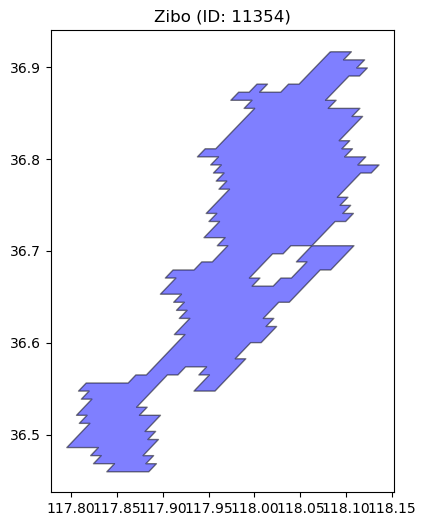

ID: 12400, Name: Shanghai
Geometry: MULTIPOLYGON (((121.10592951836124 31.50062823045384, 121.13897042310433 31.50062823045384, 121.13204389250762 31.492034999294393, 121.15406990285264 31.492034999294393, 121.14714511479917 31.483442066387386, 121.15815749050273 31.483442066387386, 121.15123507400759 31.47484943161411, 121.17325856702229 31.47484943161411, 121.18018224190983 31.483442066387386, 121.19119461761339 31.483442066387386, 121.19812192354271 31.492034999294393, 121.23116093906027 31.492034999294393, 121.21730555305176 31.47484943161411, 121.22831729955912 31.47484943161411, 121.22139348035472 31.46625709485588, 121.27644906827386 31.46625709485588, 121.28337603209594 31.47484943161411, 121.29438777860331 31.47484943161411, 121.30825197526788 31.492034999294393, 121.31926498044038 31.492034999294393, 121.32620221664853 31.50062823045384, 121.3372158515629 31.50062823045384, 121.33027798561291 31.492034999294393, 121.38534301147548 31.492034999294393, 121.37840500457382 31.483

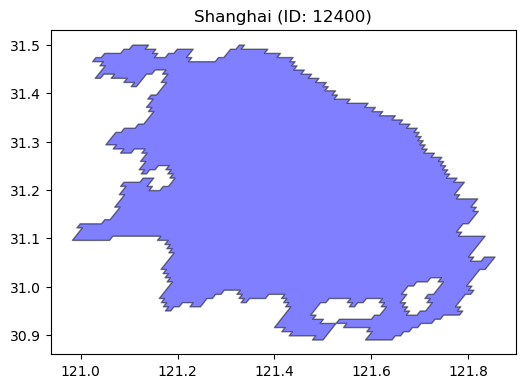

ID: 12947, Name: Takasaki [Maebashi]
Geometry: MULTIPOLYGON (((139.26918049590478 36.44240823633508, 139.28060068290733 36.44240823633508, 139.2707623128318 36.433624612682486, 139.31643983408887 36.433624612682486, 139.30660256489583 36.424841362632094, 139.340858286838 36.424841362632094, 139.3506979750317 36.433624612682486, 139.36211735534596 36.433624612682486, 139.35227686081876 36.424841362632094, 139.36369543479947 36.424841362632094, 139.35385846118604 36.416058486035936, 139.36527622918777 36.416058486035936, 139.34561364416868 36.398493852614536, 139.35702980127536 36.398493852614536, 139.3472041866166 36.38971209549362, 139.37003489099715 36.38971209549362, 139.3602119865376 36.38093071123553, 139.38304108179298 36.38093071123553, 139.3732208867935 36.37214969969257, 139.40746211704985 36.37214969969257, 139.3976438269165 36.36336906071714, 139.40905676647986 36.36336906071714, 139.3992419881857 36.35458879416165, 139.45630266849196 36.35458879416165, 139.4661214642967 36.3

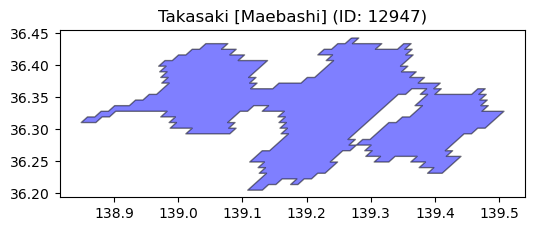

In [ ]:
# suspect UC ids
urban_center_ids = [11354, 12400, 12947]

selected_centers = gdf_urban_centres[gdf_urban_centres['ID_HDC_G0'].isin(urban_center_ids)]

#disp the geometries and names of the selection
for _, row in selected_centers.iterrows():
    print(f"ID: {int(row['ID_HDC_G0'])}, Name: {row['UC_NM_MN']}")
    print(f"Geometry: {row['geometry']}")
    print()
    
     # Plot geometry
    fig, ax = plt.subplots(figsize=(6, 6))
    gpd.GeoSeries(row['geometry']).plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')
    ax.set_title(f"{row['UC_NM_MN']} (ID: {int(row['ID_HDC_G0'])})")
    plt.show()


In [ ]:
from shapely.validation import explain_validity
from shapely import make_valid

# Fix invalid geoms
def fix_invalid_geometries(gdf):
    fixed_records = []

    for _, row in gdf.iterrows():
        geometry = row['geometry']
        if not geometry.is_valid:
            print(f"Fixing invalid geometry for ID: {int(row['ID_HDC_G0'])}, Name: {row['UC_NM_MN']}")
            explanation = explain_validity(geometry)
            print(f"Reason for invalidity: {explanation}")
            geometry = make_valid(geometry)  # Attempt to fix
        row['geometry'] = geometry
        fixed_records.append(row)

    return gpd.GeoDataFrame(fixed_records, crs=gdf.crs)

# apply the fix to selected urban centers
fixed_centers = fix_invalid_geometries(selected_centers)

# ceck if the geometrie are now valid
for _, row in fixed_centers.iterrows():
    print(f"ID: {int(row['ID_HDC_G0'])}, Name: {row['UC_NM_MN']}")
    print(f"Is Valid: {row['geometry'].is_valid}")
    print()


Fixing invalid geometry for ID: 11354, Name: Zibo
Reason for invalidity: Ring Self-intersection[118.062013715468 36.7060914075967]
Fixing invalid geometry for ID: 12400, Name: Shanghai
Reason for invalidity: Ring Self-intersection[121.526315978621 30.9255355236625]
Fixing invalid geometry for ID: 12947, Name: Takasaki [Maebashi]
Reason for invalidity: Ring Self-intersection[139.276888074338 36.2755831297423]
ID: 11354, Name: Zibo
Is Valid: True

ID: 12400, Name: Shanghai
Is Valid: True

ID: 12947, Name: Takasaki [Maebashi]
Is Valid: True



In [119]:
fixed_centers.head()

,ID_HDC_G0,QA2_1V,AREA,BBX_LATMN,BBX_LONMN,BBX_LATMX,BBX_LONMX,GCPNT_LAT,GCPNT_LON,CTR_MN_NM,...,EX_SS_P00,EX_SS_P15,EX_EQ19PGA,EX_EQ19MMI,EX_EQ19_Q,EX_HW_IDX,SDG_LUE9015,SDG_A2G14,SDG_OS15MX,geometry
11353,11354.0,1.0,457.0,36.459977,117.795192,36.917283,118.135090,36.703003,117.988470,China,...,0.000000e+00,0.000000e+00,0.080055,4.0,available,9.04060,1.4506,0.069622,41.42,"POLYGON ((118.10501 36.91728, 118.0965 36.9084..."
12399,12400.0,1.0,3318.0,30.891243,120.981413,31.500628,121.854759,31.192496,121.427128,China,...,4.650181e+06,7.561356e+06,0.075069,4.0,available,6.74476,0.65871,0.057435,36.52,"POLYGON ((121.13897 31.50063, 121.13204 31.492..."
12946,12947.0,1.0,630.0,36.205381,138.848275,36.442408,139.506740,36.332863,139.215013,Japan,...,0.000000e+00,0.000000e+00,0.429972,7.0,available,5.29943,-2.8427,0.138338,35.32,"POLYGON ((139.2806 36.44241, 139.27076 36.4336..."


In [120]:
empty = True
for _, row in fixed_centers.iterrows():
    process_urban_center(row,empty)

print("Processing complete!")

Saved: ./roads/11354_China_Zibo.geojson
Saved: ./roads/12400_China_Shanghai.geojson
Saved: ./roads/12947_Japan_Takasaki_[Maebashi].geojson
Processing complete!


Clip urban centers to exact city extent

In [ ]:
import os
import geopandas as gpd
import json
from shapely.geometry import shape, mapping

def clip_geojson_to_urban_extent(gdf_urban_centres, input_folder, output_folder):
    """
    Clips features in each GeoJSON file to the extent of the urban center polygon.
    Handles empty files and creates corresponding empty files in the output folder.
    """
    # utput directory exists?
    os.makedirs(output_folder, exist_ok=True)

    for _, row in gdf_urban_centres.iterrows():
        urban_id = int(row['ID_HDC_G0'])
        urban_polygon = row['geometry']
        country = row['XC_NM_LST'].replace(" ", "_").replace("|", "_")
        city = row['UC_NM_MN'].replace(" ", "_").replace("|", "_")

        filenames_to_check = [
            f"{urban_id}_{country}_{city}.geojson",
            f"{urban_id}.geojson",
            f"{urban_id}_empty.geojson"
        ]

        #check if file exist
        input_filename = None
        for filename in filenames_to_check:
            filepath = os.path.join(input_folder, filename)
            if os.path.exists(filepath):
                input_filename = filepath
                break

        if input_filename is None:
            print(f"No GeoJSON file found for urban center ID {urban_id}. Skipping.")
            continue

        #def output file
        output_filename = os.path.join(output_folder, os.path.basename(input_filename))

        # Skip if file already exists
        if os.path.exists(output_filename):
            print(f"Output file {output_filename} already exists. Skipping.")
            continue

        #handle empty GeoJSON files
        if "_empty" in input_filename:
            print(f"Detected empty GeoJSON: {input_filename}. Creating corresponding empty file in clean_roads.")
            empty_geojson_data = {
                "type": "FeatureCollection",
                "features": []
            }
            with open(output_filename, "w") as f:
                json.dump(empty_geojson_data, f, indent=2)
            continue

        # load geojson file
        with open(input_filename, "r") as f:
            geojson_data = json.load(f)

        clipped_features = []
        for feature in geojson_data['features']:
            feature_geometry = shape(feature['geometry'])
            #clip feature geometry to urban center polygon
            clipped_geometry = feature_geometry.intersection(urban_polygon)

            if not clipped_geometry.is_empty:
                # Add clipped feature to new collection
                feature['geometry'] = mapping(clipped_geometry)
                clipped_features.append(feature)

        # save clipped features
        clipped_geojson_data = {
            "type": "FeatureCollection",
            "features": clipped_features,
        }

        with open(output_filename, "w") as f:
            json.dump(clipped_geojson_data, f, indent=2)

        print(f"Saved clipped GeoJSON: {output_filename}")

#paths
input_folder = "./roads"
output_folder = "./clean_roads"

# clip GeoJSONs
clip_geojson_to_urban_extent(gdf_urban_centres, input_folder, output_folder)



Output file ./clean_roads\1_United_States_Honolulu.geojson already exists. Skipping.
Output file ./clean_roads\2_French_Polynesia_Papeete.geojson already exists. Skipping.
Output file ./clean_roads\3_United_States_Santa_Maria.geojson already exists. Skipping.
Output file ./clean_roads\4_United_States_Monterey.geojson already exists. Skipping.
Output file ./clean_roads\5_United_States_Santa_Barbara.geojson already exists. Skipping.
Output file ./clean_roads\6_United_States_Santa_Cruz.geojson already exists. Skipping.
Output file ./clean_roads\7_United_States_Salinas.geojson already exists. Skipping.
Output file ./clean_roads\8_United_States_Oxnard.geojson already exists. Skipping.
Output file ./clean_roads\9_United_States_Watsonville.geojson already exists. Skipping.
Output file ./clean_roads\10_United_States_San_Jose.geojson already exists. Skipping.
Output file ./clean_roads\11_United_States_Camarillo.geojson already exists. Skipping.
Output file ./clean_roads\12_United_States_Thousan

In [ ]:
folder_path = "./clean_roads"
missing_cities_clean = find_missing_files_with_id(gdf_urban_centres, folder_path)

# Print the list of missing cities
if missing_cities_clean:
    print("The following cities are missing:")
    for city in missing_cities_clean:
        print(f"ID: {city['ID']}, Country: {city['Country']}, City: {city['City']}, Reason: {city['Reason']}")
else:
    print("All urban centers have valid files.")

All urban centers have valid files.


Compute road length per tag

In [ ]:
import os
import json
import csv
from shapely.geometry import shape, LineString
from collections import defaultdict
from pyproj import CRS
from shapely.ops import transform
import pyproj


def compute_road_lengths_in_meters(geojson_file):
    """
    Computes the length of roads per highway type for a given GeoJSON file,
    and converts the lengths to meters by projecting to a suitable CRS.
    """
    with open(geojson_file, "r") as f:
        geojson_data = json.load(f)

    road_lengths = defaultdict(float)

    # fefine projection transformer
    crs_wgs84 = CRS("EPSG:4326")
    centroid = shape(geojson_data["features"][0]["geometry"]).centroid
    utm_crs = CRS.from_user_input(f"+proj=utm +zone={int((centroid.x + 180) / 6) + 1} +datum=WGS84 +units=m +no_defs")
    project = pyproj.Transformer.from_crs(crs_wgs84, utm_crs, always_xy=True).transform

    for feature in geojson_data["features"]:
        highway_type = feature["properties"]["tags"].get("highway", "unknown")
        geometry = shape(feature["geometry"])
        
        # reproj and compute length
        projected_geometry = transform(project, geometry)
        if isinstance(projected_geometry, LineString):
            road_lengths[highway_type] += projected_geometry.length
        elif projected_geometry.geom_type == "MultiLineString":
            road_lengths[highway_type] += sum(line.length for line in projected_geometry.geoms)

    return road_lengths


def generate_csv_for_urban_centers(gdf_urban_centres, input_folder, output_csv, test_id=None):
    """
    Generates a CSV file summarizing road lengths by type for each urban center.
    If test_id is specified, only processes that specific ID for testing.
    """
    results = []

    for _, row in gdf_urban_centres.iterrows():
        # extract urban center details
        urban_id = int(row["ID_HDC_G0"])
        country = row["XC_NM_LST"]
        city = row["UC_NM_MN"]

        #Skip if test_id is provided and doesn't match
        if test_id and urban_id != test_id:
            continue

        # Construct input file paths
        filenames_to_check = [
            f"{urban_id}_{country.replace(' ', '_').replace('|', '_')}_{city.replace(' ', '_').replace('|', '_')}.geojson",
            f"{urban_id}.geojson",
            f"{urban_id}_empty.geojson"
        ]
        input_filename = None
        for filename in filenames_to_check:
            filepath = os.path.join(input_folder, filename)
            if os.path.exists(filepath):
                input_filename = filepath
                break

        if input_filename is None:
            print(f"No GeoJSON file found for urban center ID {urban_id}. Skipping.")
            continue

        #empty files
        if "_empty" in input_filename:
            print(f"Empty GeoJSON file for urban center ID {urban_id}. Adding zero-length roads.")
            row_data = {
                "ID": urban_id,
                "Country": country,
                "City": city
            }
            results.append(row_data)
            continue

        print(f"Processing {input_filename}...")

        # compute road lengths by type
        road_lengths = compute_road_lengths_in_meters(input_filename)

        # result row
        row_data = {
            "ID": urban_id,
            "Country": country,
            "City": city
        }
        row_data.update(road_lengths)  # Add highway lengths to the row
        results.append(row_data)

    # to csv
    fieldnames = ["ID", "Country", "City"] + list({key for result in results for key in result.keys() if key not in ["ID", "Country", "City"]})
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
    
    print(f"CSV written to {output_csv}")


# paths
input_folder = "./clean_roads"
output_csv = "./road_lengths.csv"

# Test with ID 1 (Honolulu)
generate_csv_for_urban_centers(gdf_urban_centres, input_folder, output_csv)


Processing ./clean_roads\1_United_States_Honolulu.geojson...
Processing ./clean_roads\2_French_Polynesia_Papeete.geojson...
Processing ./clean_roads\3_United_States_Santa_Maria.geojson...
Processing ./clean_roads\4_United_States_Monterey.geojson...
Processing ./clean_roads\5_United_States_Santa_Barbara.geojson...
Processing ./clean_roads\6_United_States_Santa_Cruz.geojson...
Processing ./clean_roads\7_United_States_Salinas.geojson...
Processing ./clean_roads\8_United_States_Oxnard.geojson...
Processing ./clean_roads\9_United_States_Watsonville.geojson...
Processing ./clean_roads\10_United_States_San_Jose.geojson...
Processing ./clean_roads\11_United_States_Camarillo.geojson...
Processing ./clean_roads\12_United_States_Thousand_Oaks.geojson...
Processing ./clean_roads\13_United_States_San_Rafael.geojson...
Processing ./clean_roads\14_United_States_Los_Angeles.geojson...
Processing ./clean_roads\15_United_States_Petaluma.geojson...
Processing ./clean_roads\16_United_States_Simi_Valley.ge